In [7]:
### import modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint
from pkg.utils import seir, plot_timeseries

# Model - Waning

Here we build off the modified SEIR model to include the possible waning effect of vaccination. Protection provided by vaccination is known to decrease over time, causing the vaccinated population to become once again susceptible to the disease. Thus, it is important to explore the effect of waning on the population dynamics between the two vaccine failure modes. Similar to the other models, all variables were normalized such that $N = S + V_{S} + V_{R} + E + I + R = 1$ and vaccines were administered instantaneously. We also assume that waning starts at the same time as vaccination.

https://www.sciencedirect.com/science/article/pii/S1877750319303163

### Equations
\begin{align*}
\dot{S} &= - \beta SI - v(t)S \\
\dot{V}_{S} &= (1 - \epsilon_A)v(t)S - \beta V_{S}I + wV_{R}\\
\dot{V}_{R} &= \epsilon_A v(t)S - \beta(1-\epsilon_L)V_{R}I - wV_{R}\\
\dot{E} &= \beta (S + V_S + (1 - \epsilon_L) V_R)I - \sigma E \\
\dot{I} &= \sigma E - \gamma I \\
\dot{R} &= \gamma I \\
\end{align*}

### Variables
- $S$: Fraction of susceptible and uninfected individuals
- $V_{S}$: Fraction of vaccinated and uninfected individuals who are equally as susceptible as unvaccinated individuals 
- $V_{R}$: Fraction of vaccinated and uninfected individuals who are less susceptible than unvaccinated individuals
- $E$: Fraction of exposed individuals who are not yet infected
- $I$: Fraction of infected individuals
- $R$: Fraction of recovered individuals

### Parameters
- $\beta$: Infectiousnes of infected individuals
- $v(t)$: Fraction of population vaccinated per unit time. For an instantaneous vaccination campaign at time $t_V$ that targets a fraction $f_V$ of the population, $v(t) = f_V \delta (t - t_V)$ where $\delta$ is the Kronecker delta function. For a continuous vaccine rollout beginning at time $t_V$ at initial rate $v_{max}$ and continuing until a fraction $f_V$ of the population are vaccinated, $v(t) = v_{max}H(t-t_V)(1 - \frac{V_S + V_R}{f_V})$ where $H$ is the Heaviside step function.
- $\epsilon_A$: Efficacy of 'all-or-nothing' protection
- $\epsilon_L$: Efficacy of 'leaky' protection
- $\sigma$: Rate at which exposed individuals become infected (1 / Duration of the latent period)
- $\gamma$: Rate at which infected individuals recover (1 / Duration of the infectious period)
- $w$: Rate at which immunity of the vaccinated individauls wanes

In [3]:
def delta(t, tv):
    if (t > tv - 0.8) and (t < tv + 0.8):
        return 1
    else:
        return 0

In [4]:
def modified_seir_waning(y, t, tv, beta, sigma, gamma, fv, epsL, epsA, w):
    """
    Modified SEIR model for instantaneous vaccination. 
    """
    s, v_s, v_r, e, i, r = y
    v = fv * delta(t, tv)
    
    dsdt = - beta*s*i - v*s
    dvsdt = (1-epsA)*v*s - beta*v_s*i + w*v_r
    dvrdt = epsA*v*s - beta*(1-epsL)*v_r*i - w*v_r
    dedt = beta*(s+v_s+(1-epsL)*v_r)*i - sigma*e
    didt = sigma*e - gamma*i
    drdt = gamma*i

    return dsdt, dvsdt, dvrdt, dedt, didt, drdt

In [6]:
def run_modified_seir_waning(y0: list, t: np.ndarray, tv: int, beta: float, sigma: float, gamma: float, fv: float, \
    eps: float, w: float, mode: str = 'leaky'):
    if mode == 'leaky':
        epsL = eps; epsA = 1
    elif mode == 'aon':
        epsL = 1; epsA = eps
    else:
        print("Mode must be 'leaky' or 'aon'.")

    sim = odeint(modified_seir_waning, y0, t, args=(tv, beta, sigma, gamma, fv, epsL, epsA, w))
    s, v_s, v_r, e, i, r = sim.T
    v = v_s + v_r

    return s, v_s, v_r, v, e, i, r

# Time-Series Plots

## Pre-transmission Vaccination
Once again, we will assume that vaccination happens all at once for simplicity. Note that for a leaky vaccine, $\epsilon_A = 1$, and for an all-or-nothing vaccine, $\epsilon_L = 1$.

For the plots below, $\beta, \gamma, \sigma$ values were chosen based on the characteristics of COVID-19, and $\epsilon_L, \epsilon_A, v, w$ were arbitrary values that show the difference between the two vaccine failure mechanisms.

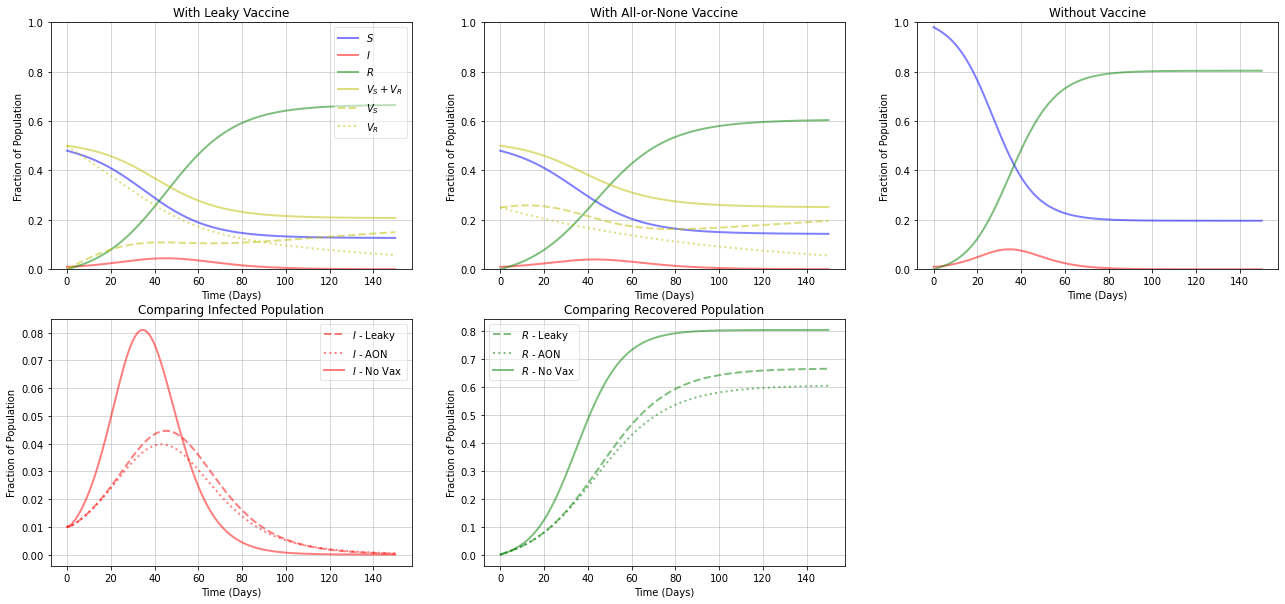

In [12]:
### run model
# set parameters
sigma = 1/4; gamma = 1/4; beta = 2 * gamma; eps = 0.5; fv = 0.5; w = 0.01
s0 = 0.98; s0_vax = 0.98 - fv; e0 = 0.01; i0 = 0.01; r0 = 0; 
t = np.linspace(0, 150, 151); tv = -1

# no vaccination
y0 = [s0, e0, i0, r0]
sim = odeint(seir, y0, t, args=(beta, sigma, gamma))
sim = sim.T

# leaky
vs0_leaky = 0; vr0_leaky = fv; y0_leaky = [s0_vax, vs0_leaky, vr0_leaky, e0, i0, r0]
sim_leaky = run_modified_seir_waning(y0_leaky, t, tv, beta, sigma, gamma, fv, eps, w, mode = 'leaky')

# aon
vs0_aon = fv*(1-eps); vr0_aon = fv*eps; y0_aon = [s0_vax, vs0_aon, vr0_aon, e0, i0, r0]
sim_aon = run_modified_seir_waning(y0_aon, t, tv, beta, sigma, gamma, fv, eps, w, mode = 'aon')

### plot time-series plot
plot_timeseries(sim, sim_leaky, sim_aon)

## 10 Days Post-Transmission Vaccination

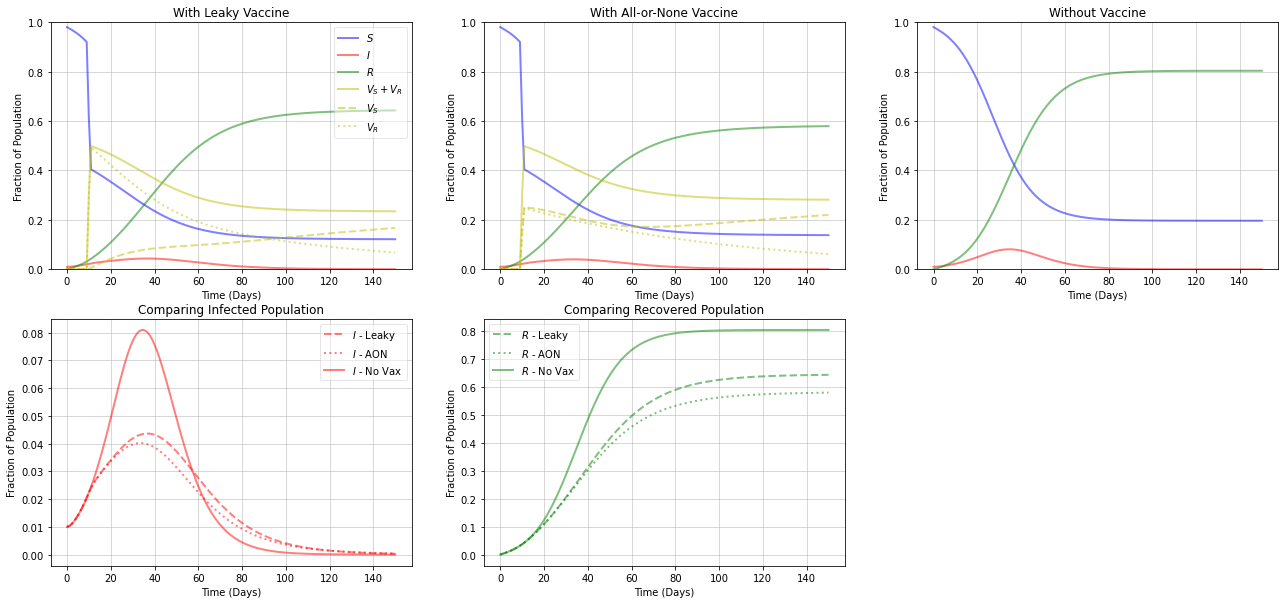

In [13]:
### run model
# set parameters
sigma = 1/4; gamma = 1/4; beta = 2 * gamma; eps = 0.5; fv = 0.5; w = 0.01
s0 = 0.98; e0 = 0.01; i0 = 0.01; r0 = 0; vs0 = 0; vr0 = 0
y0 = [s0, e0, i0, r0]; y0_vax = [s0, vs0, vr0, e0, i0, r0]
t = np.linspace(0, 150, 151); tv = 10

# no vaccination
sim = odeint(seir, y0, t, args=(beta, sigma, gamma))
sim = sim.T

# leaky
sim_leaky = run_modified_seir_waning(y0_vax, t, tv, beta, sigma, gamma, fv, eps, w, mode = 'leaky')

# aon
sim_aon = run_modified_seir_waning(y0_vax, t, tv, beta, sigma, gamma, fv, eps, w, mode = 'aon')

### plot time-series plot
plot_timeseries(sim, sim_leaky, sim_aon)

## 30 Days Post-Transmission Vaccination

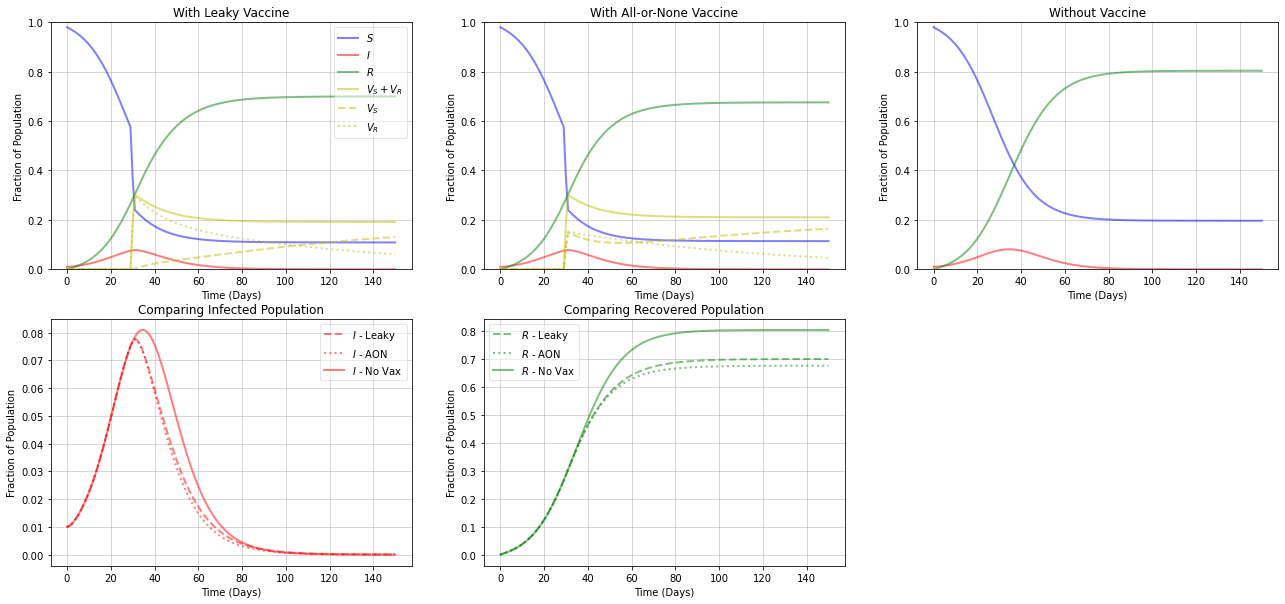

In [14]:
### run model
# set parameters
sigma = 1/4; gamma = 1/4; beta = 2 * gamma; eps = 0.5; fv = 0.5; w = 0.01
s0 = 0.98; e0 = 0.01; i0 = 0.01; r0 = 0; vs0 = 0; vr0 = 0
y0 = [s0, e0, i0, r0]; y0_vax = [s0, vs0, vr0, e0, i0, r0]
t = np.linspace(0, 150, 151); tv = 30

# no vaccination
sim = odeint(seir, y0, t, args=(beta, sigma, gamma))
sim = sim.T

# leaky
sim_leaky = run_modified_seir_waning(y0_vax, t, tv, beta, sigma, gamma, fv, eps, w, mode = 'leaky')

# aon
sim_aon = run_modified_seir_waning(y0_vax, t, tv, beta, sigma, gamma, fv, eps, w, mode = 'aon')

### plot time-series plot
plot_timeseries(sim, sim_leaky, sim_aon)